In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time

In [2]:
# Read the csv file into a DataFrame
df = pd.read_csv('Uncencored Headcount Ratio of all districts of odhisa.csv')
df_modified = df.drop( columns= 'District')
data = df_modified.values
data = data / 100

data_intervals = np.empty(data.shape + (2,))
data_intervals[:, :, 0] = data 
data_intervals[:, :, 1] = 0.01
targets = data[:, 0:1]
inputs = data_intervals[:, 1:, :]
print(inputs.shape)
print(targets.shape)

(30, 12, 2)
(30, 1)


In [3]:
# Convert NumPy arrays to PyTorch tensors
input_tensor = torch.tensor(inputs, dtype=torch.float32)
output_tensor = torch.tensor(targets, dtype=torch.float32)

In [4]:
def multiply_CRmatrix_to_scalar_matrix(A, B):
    """
    Multiply CR-type interval matrix to scalar matrix using interval operations.

    Args:
    A: torch tensor, shape (m, n, 2), CR interval matrix A
    B: torch tensor, shape (n, p), scalar matrix B

    Returns:
    C: torch tensor, shape (m, p, 2), CR interval matrix resulting from A*B where * is scalar multiplication defined above.
    """
    m, n, _ = A.shape
    n_B, p = B.shape
    assert n == n_B, "Inner dimensions must match for matrix multiplication."

    # Extract center and radius from A
    A_C = A[..., 0]  # Center matrix, shape (m, n)
    A_R = A[..., 1]  # Radius matrix, shape (m, n)
    
    # Compute the center of the resulting matrix
    C_C = torch.matmul(A_C, B)  # Shape (m, p)

    # Compute the radius of the resulting matrix
    abs_B = torch.abs(B)
    C_R = torch.matmul(A_R, abs_B)  # Shape (m, p)

    # Combine the center and radius into the resulting CR matrix
    C = torch.stack((C_C, C_R), dim=-1)
    return C


In [5]:
def apply_function_to_CR_interval(a, f):
    """
    Apply function f to a CR interval matrix a.

    Args:
    a: torch tensor, shape (m, n, 2), CR interval matrix a
    f: function to be applied element-wise

    Returns:
    result: torch tensor, shape (m, n, 2), CR interval matrix after applying f
    """
    # Extract center and radius
    a_C = a[..., 0]
    a_R = a[..., 1]

    # Apply function f to the intervals
    f_plus = f(a_C + a_R)
    f_minus = f(a_C - a_R)

    # Calculate new center and radius
    new_C = (f_plus + f_minus) / 2
    new_R = (f_plus - f_minus) / 2

    # Combine the new center and radius into the resulting CR interval matrix
    result = torch.stack((new_C, new_R), dim=-1)
    return result

In [6]:
def add_bias_to_CR_interval(XW, b):
    """
    Add bias vector b to the center of the CR interval matrix XW.

    Args:
    XW: torch tensor, shape (m, n, 2), CR interval matrix
    b: torch tensor, shape (1, n), bias vector

    Returns:
    result: torch tensor, shape (m, n, 2), CR interval matrix after adding bias
    """
    # Extract center and radius
    XW_C = XW[..., 0]  # Center part, shape (m, n)
    XW_R = XW[..., 1]  # Radius part, shape (m, n)

    # Add bias to the center part
    result_C = XW_C + b

    # Combine the new center and original radius into the resulting CR interval matrix
    result = torch.stack((result_C, XW_R), dim=-1)
    return result

In [7]:
# Splitting data into training and testing sets
train_input_tensor, test_input_tensor, train_output_tensor, test_output_tensor = train_test_split(
    input_tensor, output_tensor, test_size=0.2, random_state=1
)
print(train_input_tensor.shape, test_input_tensor.shape, train_output_tensor.shape, test_output_tensor.shape)

torch.Size([24, 12, 2]) torch.Size([6, 12, 2]) torch.Size([24, 1]) torch.Size([6, 1])


In [8]:
# Define batch size
batch_size = 8

# Create TensorDataset and DataLoader
train_dataset = TensorDataset(train_input_tensor, train_output_tensor)
test_dataset = TensorDataset(test_input_tensor, test_output_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
torch.manual_seed(2)

In [9]:
class CustomLinear(nn.Module):
    def __init__(self, input_size, output_size):
        super(CustomLinear, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(input_size, output_size))
        self.bias = nn.Parameter(torch.Tensor(1, output_size))
        self.reset_parameters()
        
    def reset_parameters(self):
        # Using Xavier initialization for weights
        nn.init.kaiming_uniform_(self.weight)
        
        # Initialize biases to zero
        nn.init.zeros_(self.bias)
    def forward(self, x):
        weighted_input = multiply_CRmatrix_to_scalar_matrix(x, self.weight)
        output = output = add_bias_to_CR_interval(weighted_input, self.bias)
        return output
        
# Define the neural network model with custom linear layers
class CustomNeuralNetwork(nn.Module):
    def __init__(self):
        super(CustomNeuralNetwork, self).__init__()
        self.layer1 = CustomLinear(input_tensor.shape[1], 16)
        self.activation = apply_function_to_CR_interval
        self.layer2 = CustomLinear(16, 16)
        self.activation = apply_function_to_CR_interval
        self.layer3 = CustomLinear(16, output_tensor.shape[1])

    def forward(self, x):
        x = self.layer1(x)
        x = self.activation(x, nn.SiLU())
        x = self.layer2(x)
        x = self.activation(x, nn.SiLU())
        x = self.layer3(x)
        return x

class IntervalMSELoss(nn.Module):
    def __init__(self, beta):
        super(IntervalMSELoss, self).__init__()
        self.beta = beta
        
    def distance(self, a, x_centre):
        return  ( a - x_centre) ** 2
    
    def forward(self, y_true, y_pred):
        y_pred_centre = y_pred[..., 0]
        y_pred_radius = y_pred[..., 1]
        y_true = y_true#.squeeze(1)
        
        d = self.distance(y_true, y_pred_centre)
        # Compute the width regularization term
        width =  (y_pred_radius) ** 2
        
        # Combine the terms to get the final loss
        loss =   d + self.beta * width
        return loss.mean()

# Initialize the model, loss function, and optimizer
model = CustomNeuralNetwork()
beta = 0.2
criterion = IntervalMSELoss(beta=beta)
optimizer = optim.AdamW(model.parameters(), lr=0.003, weight_decay=1e-1)
scheduler = StepLR(optimizer, step_size = 1000, gamma=0.5)  # Reduce LR by a factor of 0.5 every 1000 epochs

# Training the model with early stopping, validation loss tracking, and gradient clipping
patience = 500
best_loss = float('inf')
trigger_times = 0
train_losses = []
val_losses = []

# Implement gradient clipping in the training loop
max_grad_norm = 1.0

# Training the model with early stopping and validation loss tracking
epochs = 10000

start_time = time.time() # Start timer

for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0
    for batch_inputs, batch_outputs in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = criterion(batch_outputs, outputs)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        
        optimizer.step()
        epoch_train_loss += loss.item()
        
    scheduler.step()  # Step the learning rate scheduler
    epoch_train_loss /= len(train_loader)

    # Calculate validation loss
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for batch_inputs, batch_outputs in test_loader:
            val_outputs = model(batch_inputs)
            val_loss = criterion(batch_outputs, val_outputs)
            epoch_val_loss += val_loss.item()

    epoch_val_loss /= len(test_loader)

    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {epoch_train_loss:.6f}, Val Loss: {epoch_val_loss:.6f}')
    
    if epoch_val_loss < best_loss:
        best_loss = epoch_val_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break
end_time = time.time() # End timer
total_training_time_seconds = end_time - start_time
print(f"Total training time: {total_training_time_seconds/60:.2f} minutes")

Epoch 100/10000, Loss: 0.002863, Val Loss: 0.003822
Epoch 200/10000, Loss: 0.000861, Val Loss: 0.001375
Epoch 300/10000, Loss: 0.000487, Val Loss: 0.000772
Epoch 400/10000, Loss: 0.000360, Val Loss: 0.000550
Epoch 500/10000, Loss: 0.000305, Val Loss: 0.000415
Epoch 600/10000, Loss: 0.000288, Val Loss: 0.000422
Epoch 700/10000, Loss: 0.000230, Val Loss: 0.000277
Epoch 800/10000, Loss: 0.000227, Val Loss: 0.000242
Epoch 900/10000, Loss: 0.000247, Val Loss: 0.000224
Epoch 1000/10000, Loss: 0.000194, Val Loss: 0.000211
Epoch 1100/10000, Loss: 0.000183, Val Loss: 0.000188
Epoch 1200/10000, Loss: 0.000181, Val Loss: 0.000197
Epoch 1300/10000, Loss: 0.000183, Val Loss: 0.000181
Epoch 1400/10000, Loss: 0.000173, Val Loss: 0.000236
Epoch 1500/10000, Loss: 0.000178, Val Loss: 0.000166
Epoch 1600/10000, Loss: 0.000178, Val Loss: 0.000163
Epoch 1700/10000, Loss: 0.000163, Val Loss: 0.000175
Epoch 1800/10000, Loss: 0.000163, Val Loss: 0.000190
Epoch 1900/10000, Loss: 0.000163, Val Loss: 0.000198
Ep

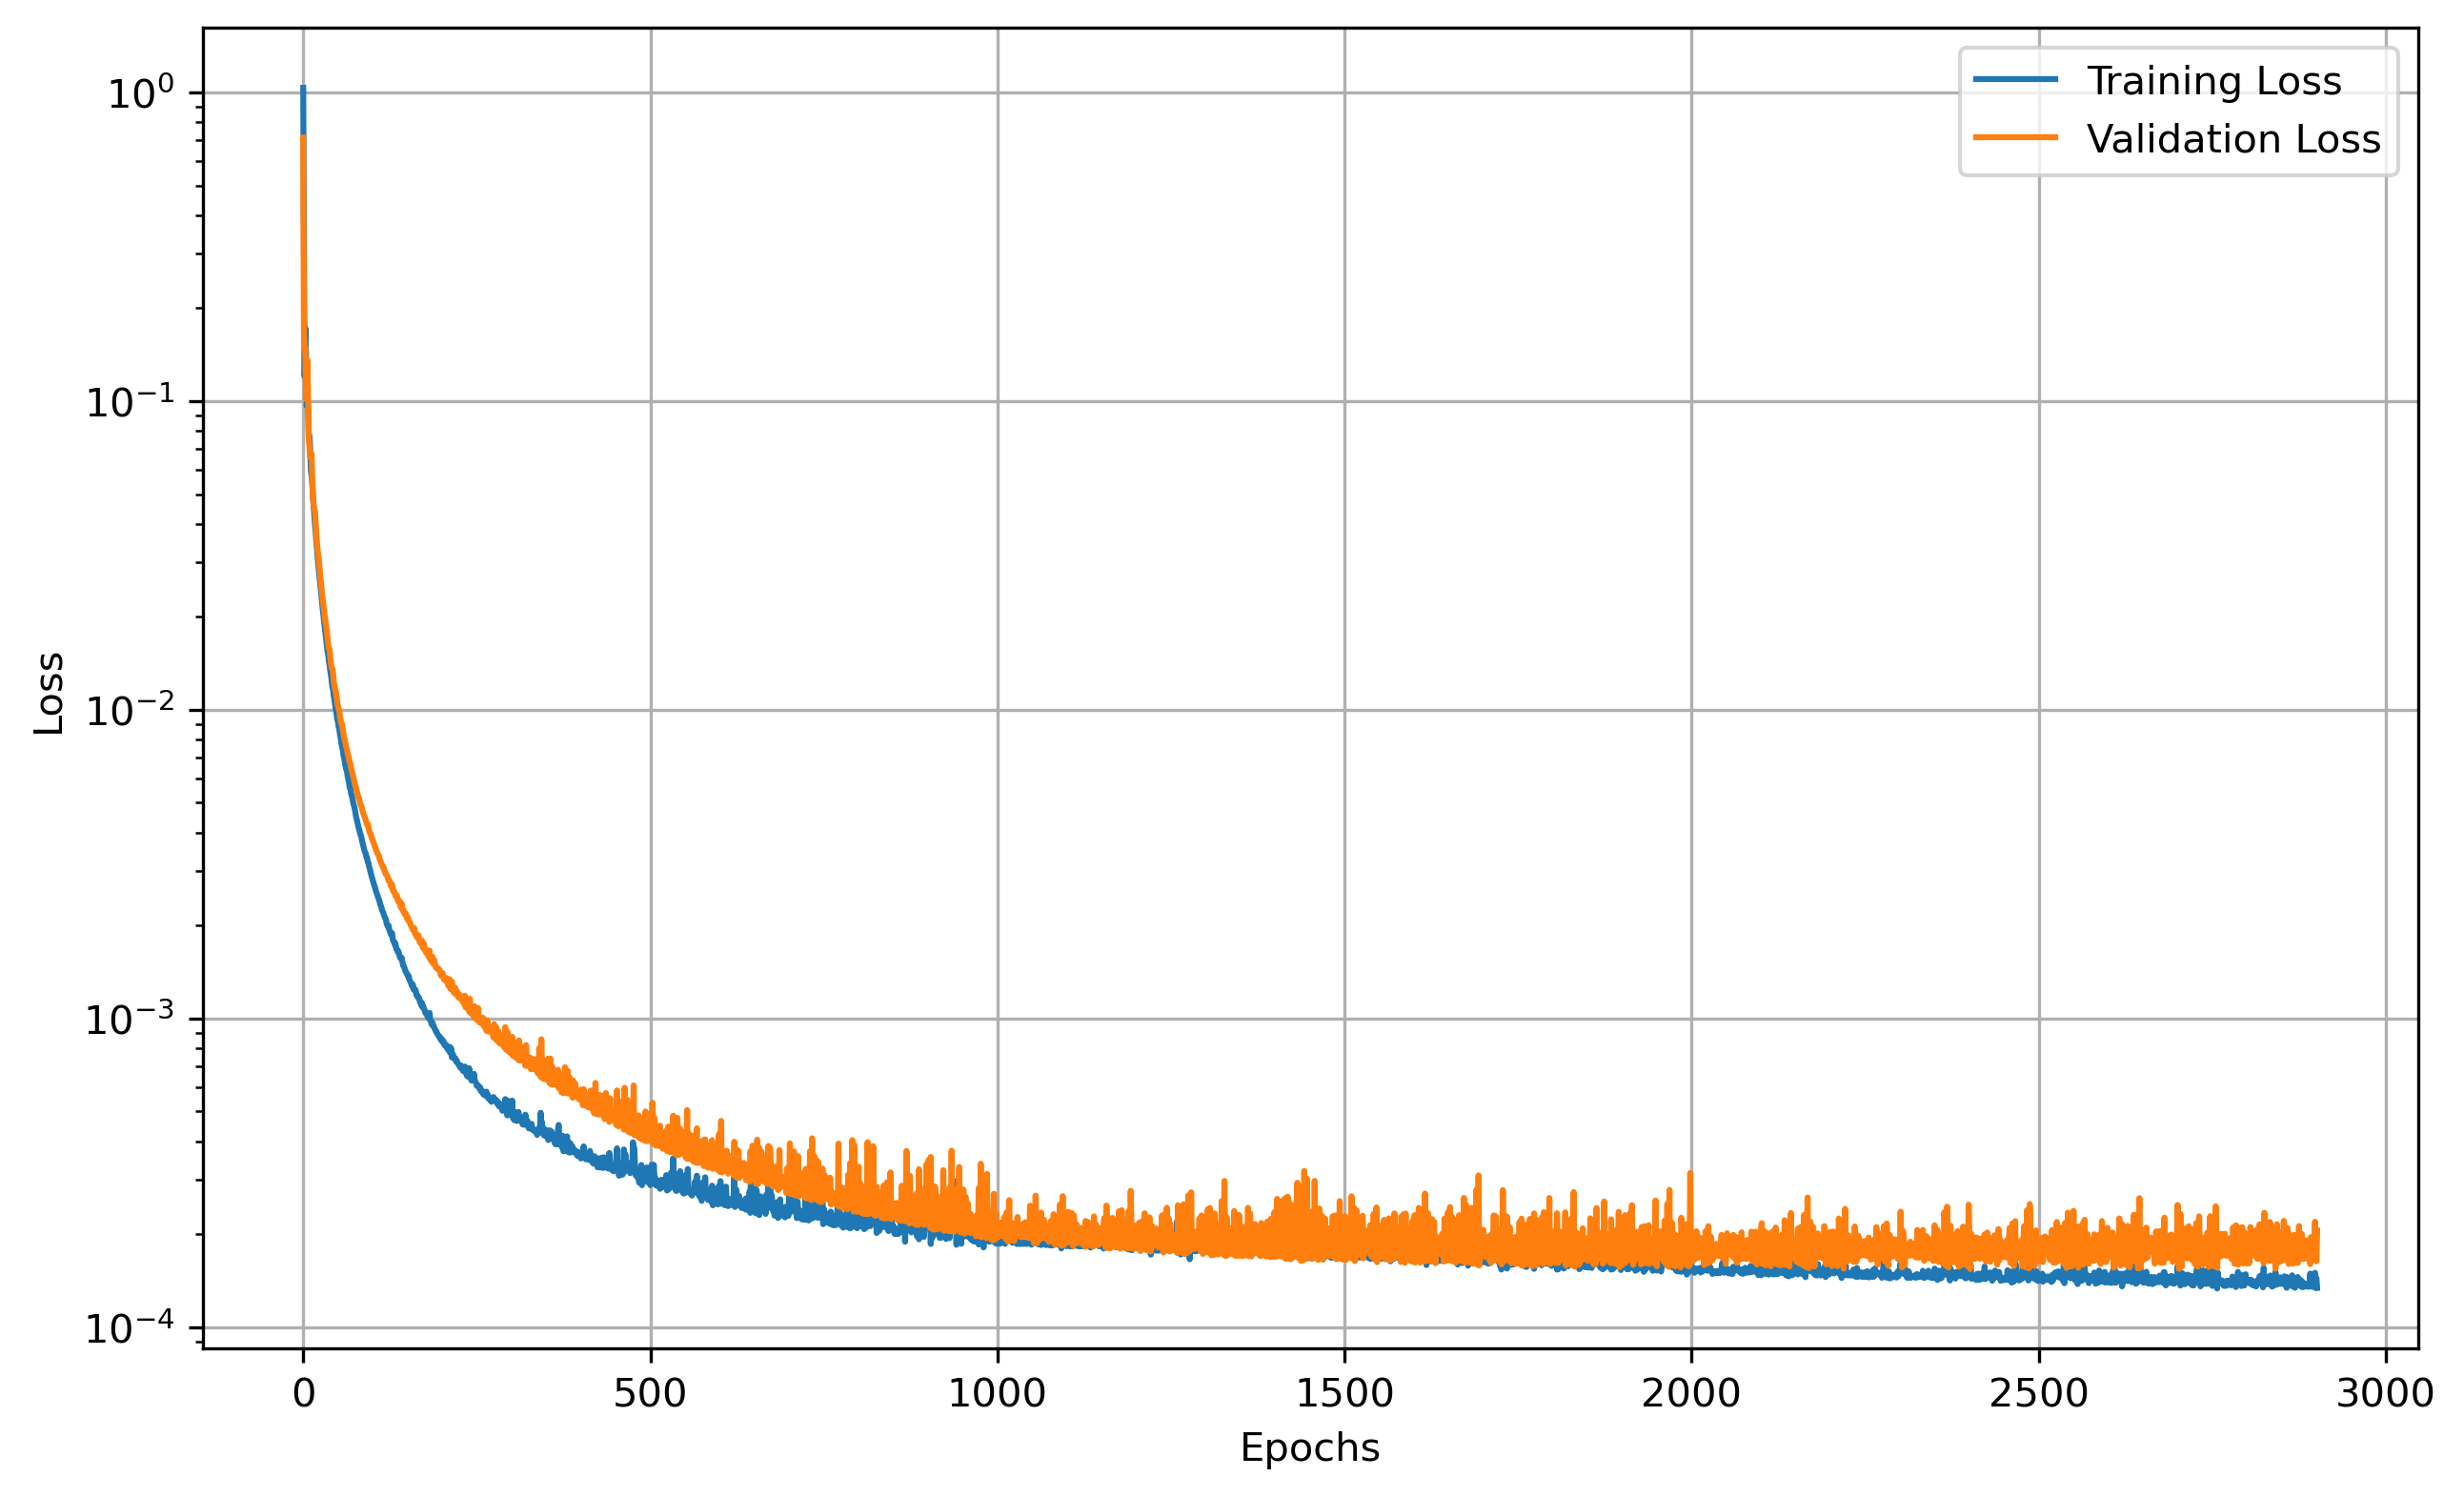

In [10]:
# Plotting training and validation loss curves
plt.figure(figsize=(10, 6), dpi = 300)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
#plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
#plt.show()
plt.savefig('Training and Validation Loss Curve.pdf')

In [11]:
outputs = model(input_tensor)
print(outputs)

tensor([[[0.2237, 0.0105]],

        [[0.3021, 0.0107]],

        [[0.2502, 0.0108]],

        [[0.2503, 0.0106]],

        [[0.3175, 0.0107]],

        [[0.2836, 0.0107]],

        [[0.1430, 0.0120]],

        [[0.3678, 0.0111]],

        [[0.2939, 0.0105]],

        [[0.3879, 0.0111]],

        [[0.2017, 0.0115]],

        [[0.1257, 0.0115]],

        [[0.2145, 0.0108]],

        [[0.1915, 0.0114]],

        [[0.4592, 0.0122]],

        [[0.4526, 0.0118]],

        [[0.2089, 0.0107]],

        [[0.4257, 0.0117]],

        [[0.1498, 0.0126]],

        [[0.5171, 0.0127]],

        [[0.5790, 0.0135]],

        [[0.4286, 0.0118]],

        [[0.5848, 0.0137]],

        [[0.2149, 0.0108]],

        [[0.3601, 0.0111]],

        [[0.1096, 0.0123]],

        [[0.4812, 0.0123]],

        [[0.2463, 0.0110]],

        [[0.2633, 0.0106]],

        [[0.2508, 0.0108]]], grad_fn=<StackBackward0>)


In [12]:
print(output_tensor)

tensor([[0.2457],
        [0.2749],
        [0.2442],
        [0.2490],
        [0.3303],
        [0.2843],
        [0.1497],
        [0.3710],
        [0.3008],
        [0.3876],
        [0.2188],
        [0.1183],
        [0.2075],
        [0.1862],
        [0.4728],
        [0.4475],
        [0.2167],
        [0.4178],
        [0.1549],
        [0.5114],
        [0.5871],
        [0.4490],
        [0.5932],
        [0.2049],
        [0.3798],
        [0.1164],
        [0.4814],
        [0.2453],
        [0.2805],
        [0.2475]])


In [13]:
# Calculate the total number of trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_params)

Total number of trainable parameters: 497


In [14]:
# Evaluate the trained model
with torch.no_grad():
    outputs = model(input_tensor)
    accuracy = (1 - torch.abs(outputs[..., 0] - output_tensor).mean()).float()
    Error = 1 - accuracy
    print(f'Accuracy: {accuracy.item():.6f}', f'Error: {Error.item():.6f}')

Accuracy: 0.991192 Error: 0.008808
